### Feature Engineering

In [3]:
from ImgPrep import file_names, read_img, reshape_array, split_img, remove_background, fix_edges, flatten_arrays, glcmm
from ImgCluster import cluster_pixels, cluster_pieces, silhouette_analysis, optimalK
from Funcs4Testing import display_cluster_imgs, display_img, img_scatter, plot_silhouette_analysis, plot_gap_stats
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from networkx.convert import to_networkx_graph as ToGraph
from collections import defaultdict
import cdlib
import joblib
import numpy as np
import pandas as pd

# list of files to read in
files = file_names('puzzle_scans/puzzle_2')
pictures = [] # picture arrays
bgremoved = [] # pic arrays with scanner background removed
avg_rgb_pieces = [] # avg rgp of the entire puzzle piece
pic_arrays = [] # flattened pic arrays
pic_arrays_filtered = [] # flattened pic arrays w/ [0,0,0] pixels filtered out
features = []

for i in range(1, len(files) + 1):
    
    # store picture as array
    pic = read_img(files, i)

    # split each image into 20 pieces
    pieces = split_img(pic, 5, 4)
    pictures += pieces
    assert all([piece.shape for piece in pieces]), 'All arrays are not the same size'

shape = pieces[0].shape

# remove scanner background from images and reshape arrays for clustering
for indx,img in enumerate(pictures):
    
    # remove background
    pic_bgremoved = remove_background(img)
    pic_bgremoved = fix_edges(pic_bgremoved, indx, shape)
    assert pic_bgremoved.shape == img.shape, \
        'Picture with background removed is not the same size as original picture'
    bgremoved.append(pic_bgremoved)
    
    # flatten picture array
    flat_pic = reshape_array(pic_bgremoved, starting_dim = len(pic_bgremoved.shape))
    assert flat_pic.shape[0] == img.shape[0] * img.shape[1], \
        'Flattened picture does not have the same number of pixels as original picture'
    pic_arrays.append(flat_pic)
    
    # find average rgb of entire piece
    keep_indices = np.where(np.sum(flat_pic, axis = 1) > 0)[0]
    flat_pic_filtered = flat_pic[keep_indices]
    pic_arrays_filtered.append(flat_pic_filtered)
    avg_rgb_pieces.append(np.mean(flat_pic_filtered, axis = 0))

assert len(bgremoved) == len(pictures), \
    'List of pictures with background removed is not the same size as original list of pictures'
assert len(pic_arrays_filtered) == len(pictures), \
    'List of flattened picture arrays is not the same size as original list of pictures'
assert len(avg_rgb_pieces) == len(pictures), \
    'Quantity of average rgb values % quantity of puzzle pieces' % ('exceeds' if len(avg_rgb_pieces) > len(pictures) else 'is less than')

joblib.dump(avg_rgb_pieces, 'pickle_files/puzzle_2/avg_rgb_pieces.pkl')
joblib.dump(bgremoved, 'pickle_files/puzzle_2/bgremoved.pkl')

# Find RGB values of cluster centers for each puzzle piece
clustered_pixels = cluster_pixels(pixels = pic_arrays_filtered, n_clusters = 3)
joblib.dump(clustered_pixels, 'pickle_files/puzzle_2/clustered_pixels.pkl')

# flatten cluster centers to use in features
centers_flattened = flatten_arrays(clustered_pixels)
joblib.dump(centers_flattened, 'pickle_files/puzzle_2/centers_flattened.pkl')

# avg_rgb_pieces = joblib.load('pickle_files/puzzle_1/avg_rgb_pieces.pkl')
# bgremoved = joblib.load('pickle_files/puzzle_1/bgremoved.pkl')
# centers_flattened = joblib.load('pickle_files/puzzle_1/centers_flattened')

# find texture features   
txtr_features = np.empty((len(bgremoved),24))
for indx,img in enumerate(bgremoved):
    txtr_features[indx] = glcmm(img)
    
# concatenate all features for clustering pieces
feature_set =  np.concatenate((avg_rgb_pieces, centers_flattened, txtr_features), axis = 1)

### Clustering

Optimal k is: 9


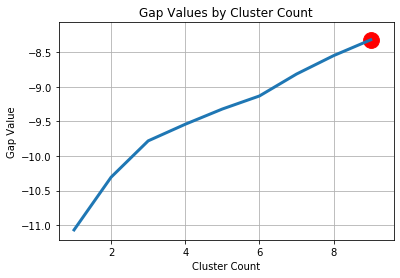

In [4]:
# perform silhouette analysis to determine optimal k for clustering
# range_n_clusters = np.arange(2,11)

# for n_clusters in range_n_clusters:
#     sample_silhouette_values, cluster_labels = silhouette_analysis(feature_set, n_clusters)
#     plot_silhouette_analysis(feature_set, sample_silhouette_values, cluster_labels, n_clusters)

# calculate gap-statistic to determine optimal k for clustering
k, gapdf = optimalK(feature_set, maxClusters = 10)
print(f'Optimal k is: {k}')

plot_gap_stats(gapdf, k)

In [22]:
# perform Isomap and PCA on final feature set
km_iso_models = defaultdict(dict)
km_pca_models = defaultdict(dict)

for i in range(2, 15):
    # perform KMeans clustering on isomap reduction
    iso_name = 'isoKM_' + str(i)
    iso = Isomap(n_components = i).fit_transform(feature_set)
    km_iso_models[iso_name]['reduced_features'] = iso
    km_iso_models[iso_name]['model'] = KMeans(n_clusters = i).fit(iso)
    
    # perform KMeans clustering on pca reduction
    pca_name = 'pcaKM_' + str(i)
    pca = PCA(n_components = i).fit_transform(feature_set)
    km_pca_models[pca_name]['reduced_features'] = pca
    km_pca_models[pca_name]['model'] = KMeans(n_clusters = i).fit(pca)

# perform k-means clustering on all features
km = KMeans(n_clusters = k).fit(feature_set)

# Spectral clustering on all features
sc = SpectralClustering(n_clusters = k, assign_labels = "discretize", random_state = 5).fit(feature_set)

In [23]:
[km_pca_models[x].keys() for x in km_pca_models]

[dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model']),
 dict_keys(['reduced_features', 'model'])]

### Goodness of Fit
[Evaluation metrics provided by 'cdlib' package](https://cdlib.readthedocs.io/en/latest/reference/classes/node_clustering.html#methods)

[Additional cdlib documentation](https://cdlib.readthedocs.io/_/downloads/en/stable/pdf/)

* conductance (desired trend to be low)
* newman girvan modularity (desired trend to be high). between 0 and 1 and 1 is good.

In [24]:
# compare clusters to adjacency graph
adj = np.loadtxt('AdjacencyMatrices/Puzzle1_AdjacencyMatrix.csv', delimiter = ',', dtype=int)
assert adj.shape[0] == adj.shape[1], 'Adjacency matrix must be symmetrical'
assert adj.shape[0] == len(pictures), 'Adjacency matrix should have one row and one column for every puzzle piece'

# Convert the adjacency matrix into a NetworkX graph object
adjG = ToGraph(adj)

# store indices of each cluster in list of lists
model_dict = defaultdict(dict)
all_models = [km, sc] + [km_iso_models[x]['model'] for x in km_iso_models] + [km_pca_models[x]['model'] for x in km_pca_models]
all_names = ['KMeans', 'SpectralClustering'] + list(km_iso_models.keys()) + list(km_pca_models.keys())

# create data frame to store comparison results
model_comparison = pd.DataFrame({'model_name': all_names, 'modularity_score' : [0] * len(all_names), 'conductance_score': [0] * len(all_names)})

for name,model in zip(all_names, all_models):
    
    clusters = []
    
    for i in range(k):
        i_indices = np.where(model.labels_ == i)[0].tolist()
        clusters.append(i_indices)
    model_dict[name]['clusters'] = clusters
    
    Comms = cdlib.NodeClustering(clusters, adjG, 'Manual')
    model_dict[name]['Comms'] = Comms
    
    # Using the object created above, many 'fitness' metrics can be calculated
    modularity = cdlib.evaluation.newman_girvan_modularity(adjG, Comms)
    conductance = cdlib.evaluation.conductance(adjG, Comms)
    model_comparison.loc[model_comparison.model_name == name, ['modularity_score','conductance_score']] = [round(x,4) for x in [modularity.score, conductance.score]]

model_comparison.sort_values(by = ['conductance_score', 'modularity_score'], ascending = [True, False], inplace = True)
model_comparison

[dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model'])]
[dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', 'model']), dict_keys(['reduced_features', '

,model_name,modularity_score,conductance_score
2,isoKM_2,-0.0000,0.1114
15,pcaKM_2,-0.0122,0.1164
3,isoKM_3,-0.0011,0.2249
16,pcaKM_3,-0.0037,0.2255
17,pcaKM_4,-0.0007,0.3350
4,isoKM_4,-0.0028,0.3384
18,pcaKM_5,0.0003,0.4449
5,isoKM_5,-0.0038,0.4526
19,pcaKM_6,-0.0048,0.5601
6,isoKM_6,-0.0024,0.5677



Images in cluster 7:



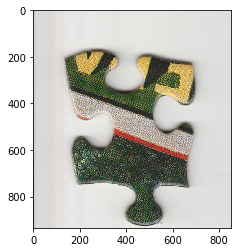

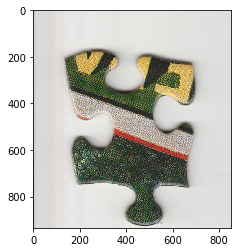

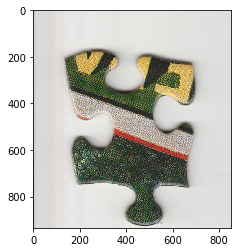

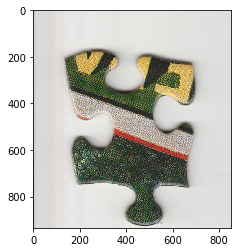

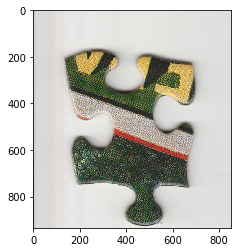

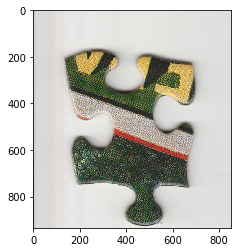

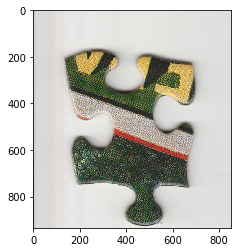

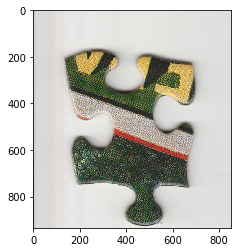

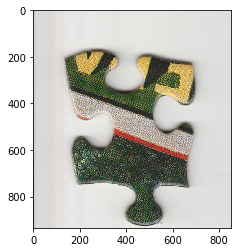

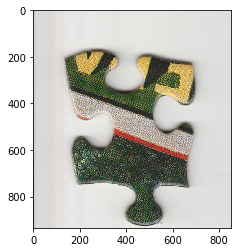

In [45]:
display_cluster_imgs(pictures, selectedDict['isoKM_14']['model'].labels_, 7)


Images in cluster 1:



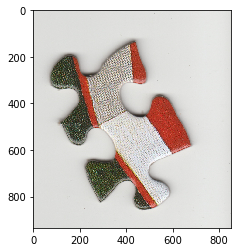

In [40]:
import re

# visual check of best performing model
model2viz = model_comparison.iloc[0,0]
selectedDict = km_iso_models if re.search(r'iso', model2viz) is not None else km_pca_models
# img_scatter(selectedDict[model2viz]['reduced_features'], pictures, 100)

# visual inspection of KMeans clusters
display_cluster_imgs(pictures, selectedDict[model2viz]['model'].labels_, 1)

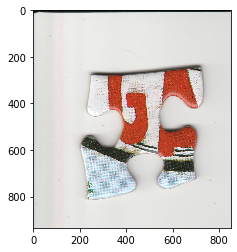

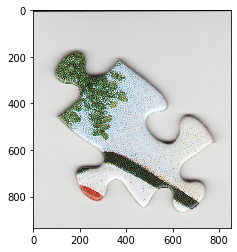

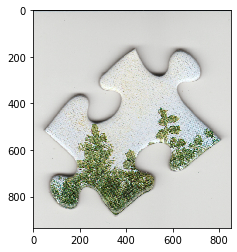

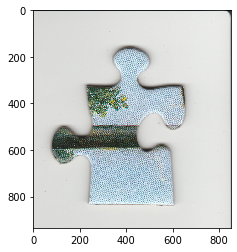

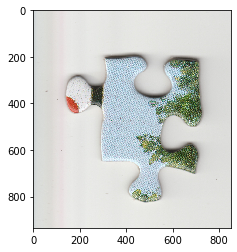

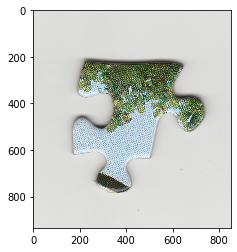

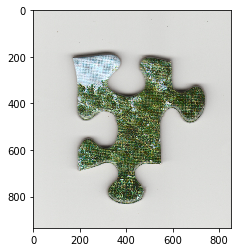

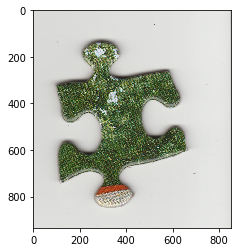

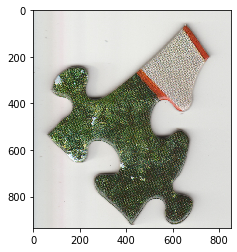

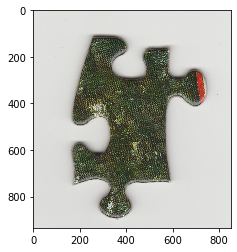

In [41]:
for img in pictures[:10]:
    display_img(img)